UFMG - Trabalho Prático 1 - Aprendizado de Máquina

Aluno: Paulo Henrique de Souza Coelho

Os métodos serão testados em um problema de classificação de candidatos a exoplanetas encontrados pela sonda espacial Kepler da NASA. 
Um exoplaneta é um planeta fora do sistema solar (i.e. que não orbita o nosso sol). A sonda primeiro identifica sinais de possíıveis exoplanetas, chamados de Kepler Object of Interest (KOI). Porém nem todos os KOIs são de fato exoplanetas, alguns se tratam de "Falsos Positivos" de origens diversas. A tarefa é então classificar os KOIs entre exoplanetas confirmados e "Falsos Positivos". Cada observação corresponde a um KOI e as features são características estimadas de cada (possível) exoplaneta (tamanho, temperatura, features da estrela hospedeira, etc).

Os dados estão armazenados em um repositório do Github, sendo necessário importar usando a URL. Após a importação dos dados é realizada a divisão entre y - coluna de dados "koi_disposition", que indica se o exoplaneta é confirmado ou falso positivo e x - as demais colunas dos dados exceto a que contém o nome do planeta, por ser um dado irrelevante para a modelagem. 

Os dados são separados em treino e teste, com tamanho de teste igual à 0.3, ou seja, 30% dados de teste e 70% de dados de treino.

Para cada um dos seis modelos treiandos é realizada a medição de acurácia, K-Folds Cross-Validation com K=5 e a impressão do classification_report que irá imprimir uma tabela contendo (entre outros) os valores de precision, recall e f1-score.

Acurácia é uma medida de performance como sendo a razão entre observações corretamente observadas sobre o total de observações, o recall  é a razão das observações corretamente observadas sobre todas as observações na classe atual. Geralmente valores de recall acima de 0.5 são considerados bons. Finalmente, o f1-score é a média ponderadas de Precision e Recall, esse modelo leva em conta ambos falsos positivos e falsos negativos.

In [ ]:
#importando as bibliotecas necessárias

import pandas as pd
import numpy as np
from numpy import mean
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from scipy import stats
from sklearn import tree, neighbors
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut,KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc

%matplotlib inline

In [ ]:
#Carregando os dados, realizando a divisão entre treino e teste, e normalizando

SEED = 50

url = "https://raw.githubusercontent.com/paulohdscoelho/ml/master/TP1/koi_data.csv"
df = pd.read_csv(url)
x = df.drop('koi_disposition', axis=1).drop('kepoi_name', axis=1)
y = df['koi_disposition'].map({"CONFIRMED":1,"FALSE POSITIVE":0})
df.drop('kepoi_name', inplace=True, axis=1)

treino_x, teste_x, treino_y, teste_y = train_test_split(x, y, random_state = SEED, test_size = 0.3, stratify = y)
treino_x = treino_x.values
teste_x = teste_x.values

scaler = MinMaxScaler()
treino_x_norm = scaler.fit_transform(treino_x)
teste_x_norm = scaler.fit_transform(teste_x)


NAIVE BAYES: 
O objetivo desse método é apenas servir de baseline para comparar com os demais, portanto foi feito apenas um treino básico com impressão de acurácia e relatório de classficação. 
A acurácia do Naive Bayes foi baixa, apenas 79.95%. Em compensação a precisão para os valores de Falso Postivo foi alta, chegando a 98%, enquanto o recall para a classe Confirmado chegou a 98% também.

In [ ]:
#NAIVE BAYES
print("NAIVE BAYES")

gaus_nb = GaussianNB().fit(treino_x, treino_y)
previsoes = gaus_nb.predict(teste_x)
acuracia = accuracy_score(teste_y, previsoes) * 100

# K-fold (k=5)
scores = cross_val_score(gaus_nb, x, y, cv=5, scoring='accuracy')

# Results
print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

# Imprimindo o quão acurado foi o modelo
print("A acurácia de Naive Bayes foi %.2f%%\n" % acuracia)
# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(teste_y, previsoes)) 


NAIVE BAYES
K-Fold Cross Validation Accuracy: 0.80 (+/- 0.09)

A acurácia de Naive Bayes foi 79.95%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.98      0.68      0.80       930
           1       0.67      0.98      0.80       631

    accuracy                           0.80      1561
   macro avg       0.83      0.83      0.80      1561
weighted avg       0.85      0.80      0.80      1561



ÁRVORE DE DECISÃO:
É um método de aprendizagem supervisionada não paramétrico usado para classificação e regressão. O objetivo é criar um modelo que prevê o valor de uma variável de destino, aprendendo regras de decisão simples inferidas a partir dos recursos de dados.

O parâmetro ajustado será será max_depth. Isso indica o quão profunda a árvore pode ser. Quanto mais profunda a árvore, mais divisões ela tem e captura mais informações sobre os dados. Iremos variar o max_depth de valores que variam de 3 (3 árvores de decisão) a None (infinitas árvores). 

Após o treino são impressas as métricas de acurácia, precision    recall e f1-score, além de plotar as árvores de decisão obtidas em cada teste. As métricas de precision e recall atingem valores altos para todas as árvores, variando de 94 a 97%.

Nota-se que a acurácia da Árvore de Decisão é maior do que o Naive Bayes, mas à medida que variamos as árvore, a acurácia tende a diminuir um pouco, sendo o melhor desempenh obtido com nro de árvores igual a 10 (95,90%) e com 1000 e None (infinito) árvores, a acurácia atinge um valor mais baixo de 94.94%.

Ao fim do experimento são impressas as árvores de decisão obtidas para cada valor de árvore, utilizando o método tree.plot. Nota-se que as árvores crescem bastante com a variação do método max_depth. Note que para os valores de max_depth 1000 e None (infinito) a árvore obtida possui mesma altura. Isso se dá pois só existem 42 features nos dados de treino.

ARVORE DE DECISÃO
K-Fold Cross Validation Accuracy: 0.92 (+/- 0.05)

A acurácia de Decision Tree max_depth 3 foi 93.85%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       930
           1       0.92      0.93      0.92       631

    accuracy                           0.94      1561
   macro avg       0.94      0.94      0.94      1561
weighted avg       0.94      0.94      0.94      1561

K-Fold Cross Validation Accuracy: 0.94 (+/- 0.04)

A acurácia de Decision Tree max_depth 10 foi 95.90%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       930
           1       0.94      0.96      0.95       631

    accuracy                           0.96      1561
   macro avg       0.96      0.96      0.96      1561
weighted avg       0.96      0.96      0.96      1561

K-Fold Cross Validation Accuracy: 0.94 (+/- 0.04)

A acurácia

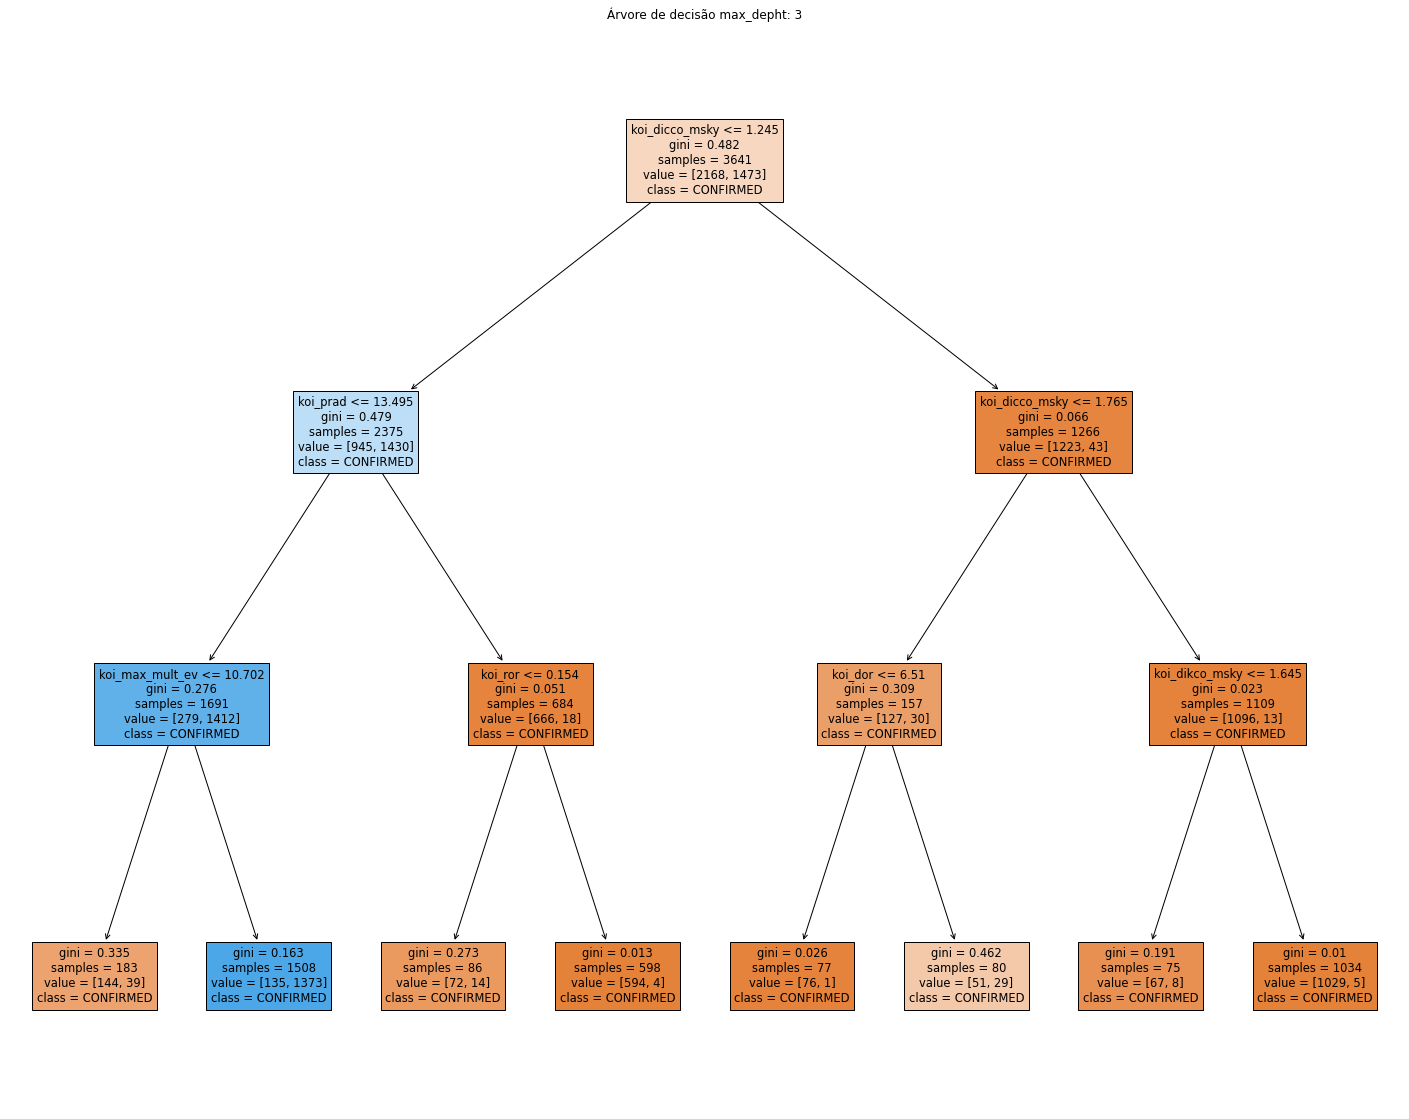

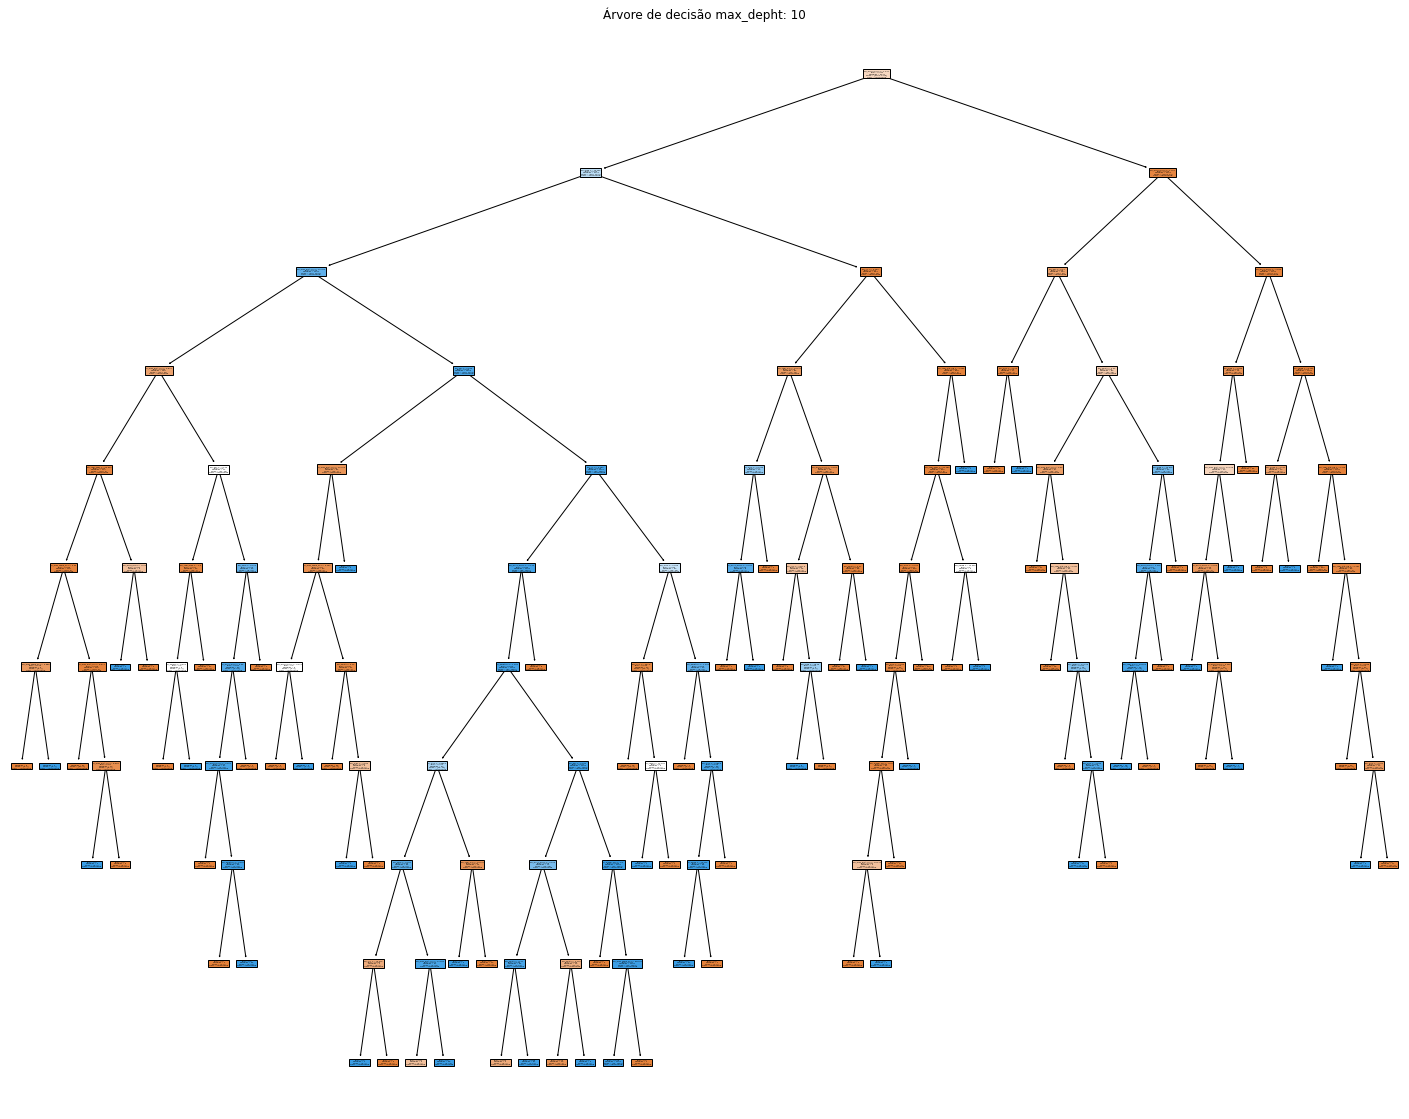

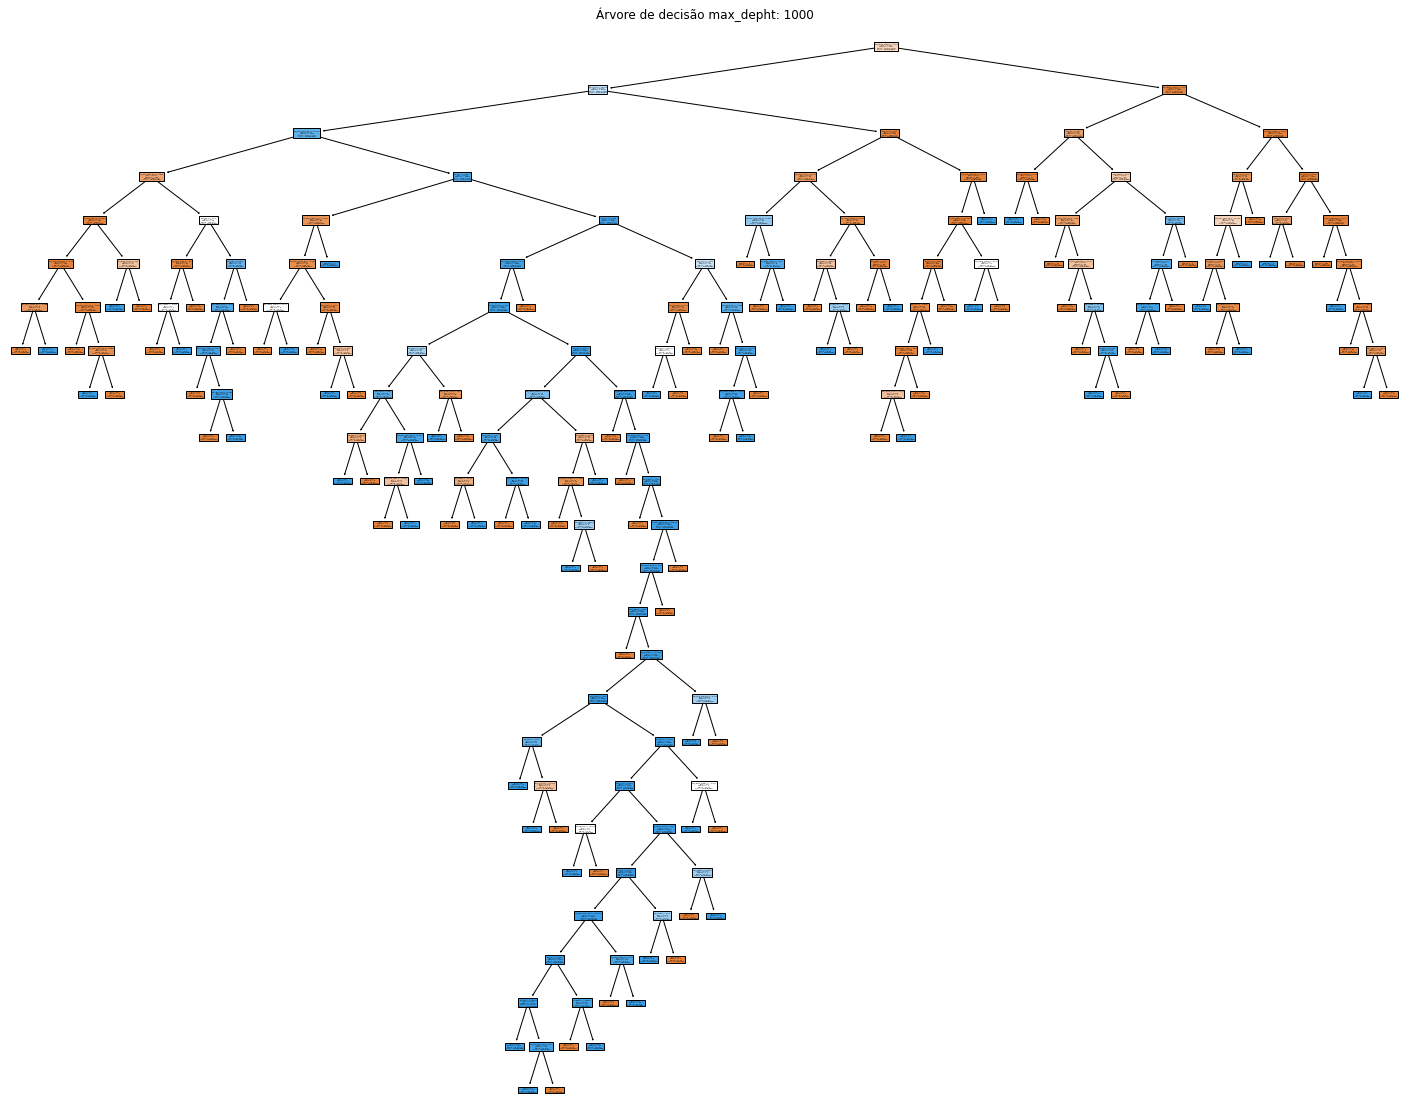

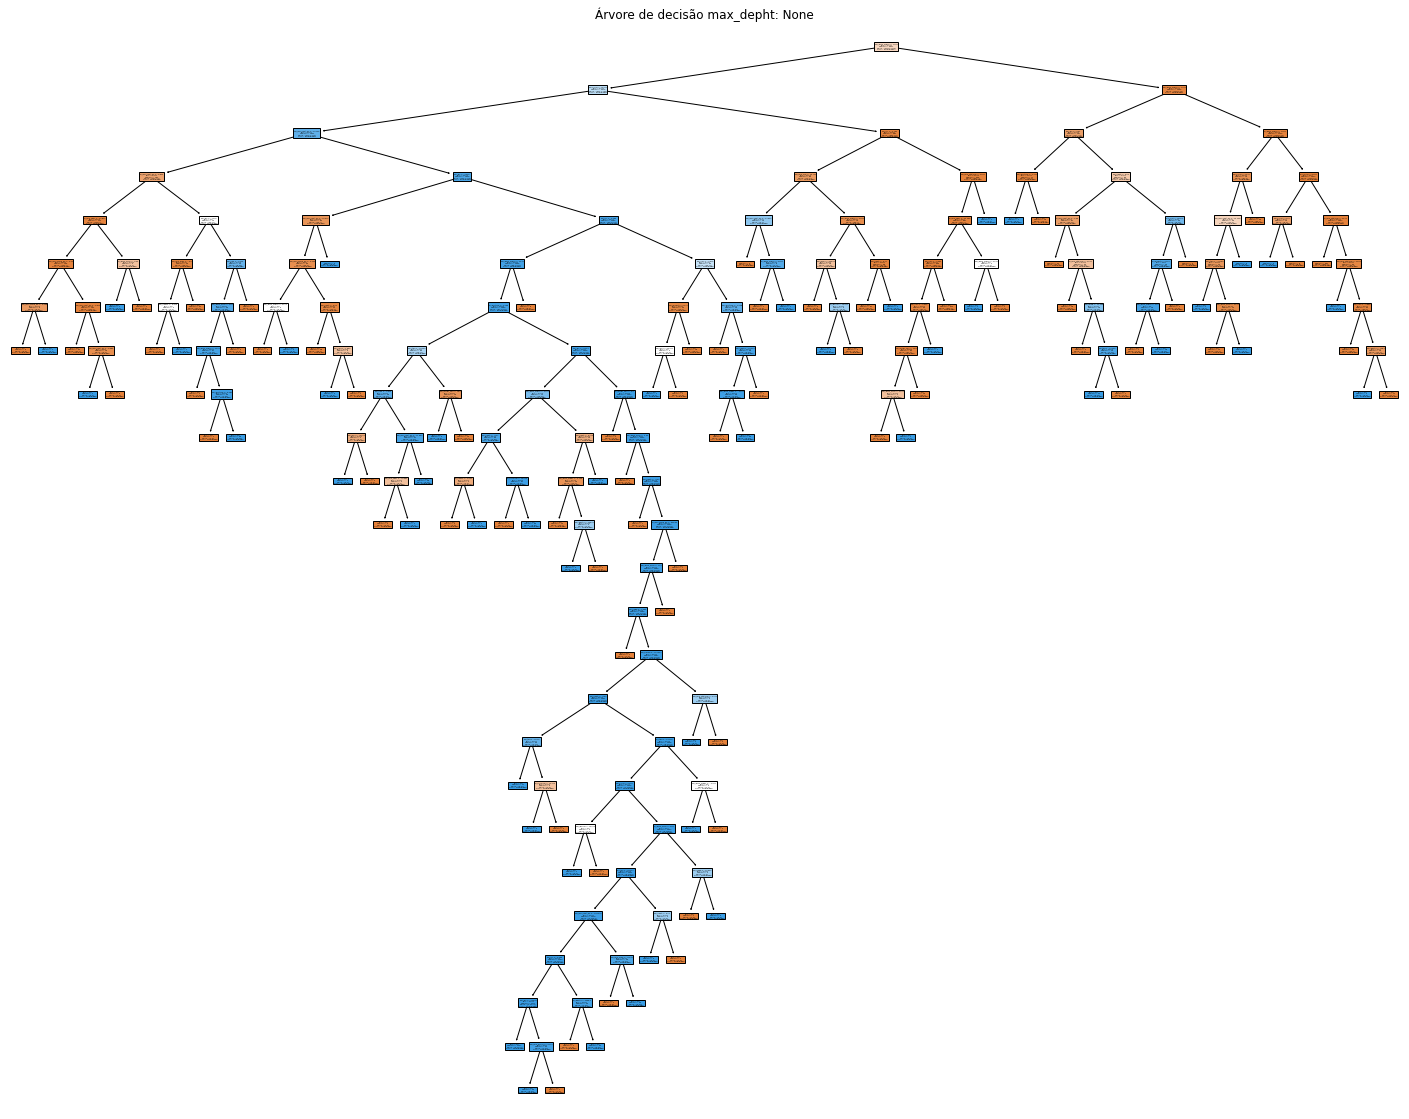

In [ ]:
#ARVORE DE DECISÃO
print("ARVORE DE DECISÃO")

depth = [3,10,1000,None]

for d in depth:
  tree_clf = tree.DecisionTreeClassifier(random_state=SEED,max_depth=d).fit(treino_x, treino_y)
  previsoes = tree_clf.predict(teste_x)
  acuracia = accuracy_score(teste_y, previsoes) * 100
  
  # K-fold (k=5)
  scores = cross_val_score(tree_clf, x, y, cv=5, scoring='accuracy')

  # Results
  print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

  # Imprimindo o quão acurado foi o modelo
  print("A acurácia de Decision Tree max_depth %s foi %.2f%%\n" % (d, acuracia))

  # Imprimindo o relatório de classificação
  print("Relatório de classificação: \n", classification_report(teste_y, previsoes)) 

  #Plotando árvore de decisão
  fig = plt.figure(figsize=(25,20))
  _ = tree.plot_tree(tree_clf,
                    max_depth=d,
                    feature_names=x.columns,
                    class_names=df['koi_disposition'],
                    filled=True)
  plt.title("Árvore de decisão max_depht: {}".format(d))


SVM: O SVM classifica os pontos de dados usando uma linha reta. Alguns conjuntos de dados são impossíveis de separar por linha reta. Para lidar com esse problema, a função do kernel é utilizada. A idéia central da função kernel é projetar pontos em uma dimensão mais alta do espaço na esperança de que a separabilidade dos dados iria melhorar.

Para o SVM são usados os dados de teste e treino normalizados utilizando o MinMaxScaler que normaliza em uma faixa de valores entre 0 e 1. Esse passo foi realizado pois o SVM espera dados linearmente separáveis.

Para esse trabalho foram testados os kernels POLY, RBF e SIGMOID.
Conforme os resultados apresentados abaixo, o SVM performa muito bem para o kernel POLY, obtendo uma acurácia alta (92.06%).

Já o kernel SIGMOID apresenta uma acurácia baixa (45.42%). Isso se dá pois o kernel SIGMOID performa melhor em classificação binária, como os dados do KOI são de classificação multi-classe o SIGMOID não performa tão bem quanto outros modelos.

As métricas de precision, recall e f1-score também atingiram valores altos para os kernels linear, poly e rbf: chegando a 99% de recall para os valores de 0 usando kernel rbf. Já o f1-score obteve valores altos para todos os kernels com exceção do sigmoid, que atinge valores de 33% para 0 e 55% para 1.

Para este experimento tentei usar o kfold mas entrou em loop infinito, portanto não é calculada essa métrica nesse modelo.

In [ ]:
#SVM MODEL COM KERNELS DIFERENTES
print("SVM")

kernels=['linear','poly','rbf','sigmoid']

for k in kernels:
  SVM_clf = SVC(kernel=k,
                random_state=SEED).fit(treino_x_norm, treino_y)

  previsoes = SVM_clf.predict(teste_x_norm)
  acuracia = accuracy_score(teste_y, previsoes) * 100

#Ao tentar calcular kfold para o SVM o código entra em loop infinito
  # # K-fold (k=5)
  # scores = cross_val_score(SVM_clf, x, y, cv=5, scoring='accuracy')

  # # Results
  # print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

  # Imprimindo o quão acurado foi o modelo
  print("A acurácia do SVM com kernel %s foi %.2f%%\n" % (k,acuracia))

  # Imprimindo o relatório de classificação
  print("Relatório de classificação: \n", classification_report(teste_y, previsoes)) 
 

SVM
A acurácia do SVM com kernel linear foi 91.42%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.96      0.90      0.93       930
           1       0.86      0.94      0.90       631

    accuracy                           0.91      1561
   macro avg       0.91      0.92      0.91      1561
weighted avg       0.92      0.91      0.91      1561

A acurácia do SVM com kernel poly foi 92.06%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.93       930
           1       0.93      0.87      0.90       631

    accuracy                           0.92      1561
   macro avg       0.92      0.91      0.92      1561
weighted avg       0.92      0.92      0.92      1561

A acurácia do SVM com kernel rbf foi 74.95%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.71      0.99      0.83       930
    

KNN: O algoritmo de kNN é um método de aprendizagem não-paramétrico usado para classificação e regressão. A saída é com base no voto da maioria (para classificação) ou média (ou mediana, para regressão) dos k vizinhos mais próximos no espaço de features.
Para este trabalho foram variados vizinhos entre 1 e 10. Os resultados para cada vizinho são apresentados na forma de acurácia,precision, recall e f1-score.

É apresentado também um gráfico mostrando o desempenho do AUC Score para cada vizinho e outro gráfico representando a taxa de erro variando para cada vizinho. Conforme mostrado pelo primeiro gráfico, à medida que o número de vizinhos aumenta a curva de traino e de teste tendem a convergir. Já o segundo gráfico deixa evidente que o erro tende a cair conforme se aumenta o número de vizinhos, convergindo para zero.

Notamos que a acurácia do modelo aumenta à medida que o número de vizinhos aumenta, partindo de 75.98% com 1 vizinho e chegando a 80.33% com K=10. Nota-se também que a taxa de erro cai consideravelmente conforme o valor de k aumenta à partir do valor k=5, o que pode ser interpetado como um modelo com menos overfitting à medida que se varia o k.

O valor da acurácia de K-Fold Cross Validation cresce consistentemente um ponto percentual à medida que se varia o k. O f1-score calcula valores altos para a classe 0 e baixos para a 1, ambos valores também crescem à medida que se varia o k. Já o valor de recall varia de forma menos óbvia, sendo maior em alguns valores de k e menor em outros, mas sempre variando em valores próximos a 80%.


KNN
K-Fold Cross Validation Accuracy: 0.76 (+/- 0.08)

A acurácia do KNN com 1 vizinhos foi: 75.98%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.83      0.75      0.79       930
           1       0.68      0.77      0.72       631

    accuracy                           0.76      1561
   macro avg       0.75      0.76      0.76      1561
weighted avg       0.77      0.76      0.76      1561

K-Fold Cross Validation Accuracy: 0.75 (+/- 0.05)

A acurácia do KNN com 2 vizinhos foi: 75.53%

Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       930
           1       0.75      0.60      0.66       631

    accuracy                           0.76      1561
   macro avg       0.75      0.73      0.74      1561
weighted avg       0.75      0.76      0.75      1561

K-Fold Cross Validation Accuracy: 0.76 (+/- 0.08)

A acurácia do KNN com 3 vizinhos foi:

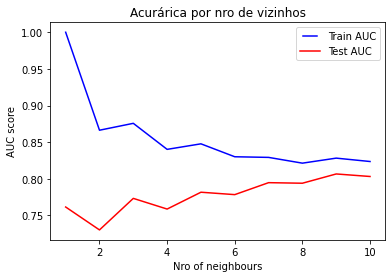

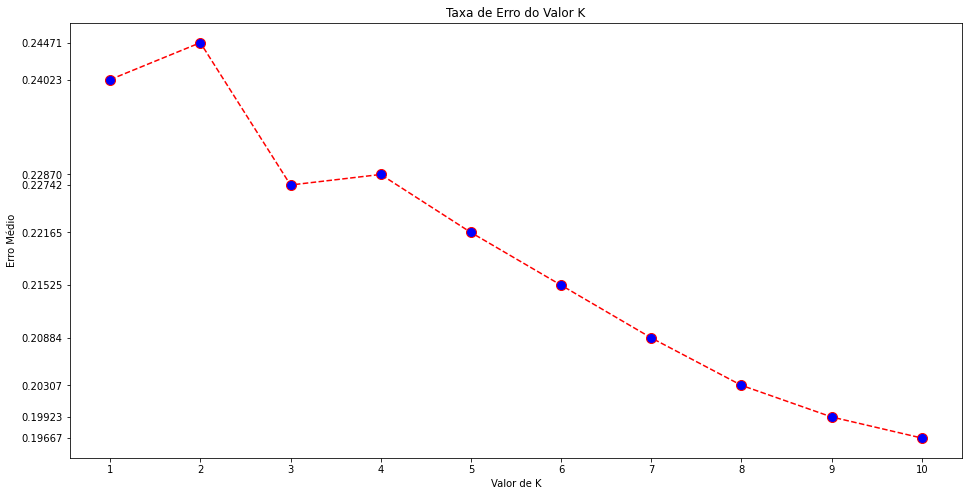

In [ ]:
#KNN
print("KNN")

vizinhos = [1,2,3,4,5,6,7,8,9,10]

train_results = []
test_results = []

erro = []
for v in vizinhos:
  k_neigh = KNeighborsClassifier(n_neighbors=v).fit(treino_x, treino_y)
  previsoes = k_neigh.predict(teste_x)
  acuracia = accuracy_score(teste_y, previsoes) * 100
  erro.append(np.mean(previsoes != teste_y))
    
  train_pred = k_neigh.predict(treino_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(treino_y, train_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)
  y_pred = k_neigh.predict(teste_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(teste_y, y_pred)
  roc_auc = auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

  # K-fold (k=5)
  scores = cross_val_score(k_neigh, x, y, cv=5, scoring='accuracy')

  # Results
  print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

  # Imprimindo o quão acurado foi o modelo
  print("A acurácia do KNN com %d vizinhos foi: %.2f%%\n" %(v,acuracia))

  # Imprimindo o relatório de classificação
  print("Relatório de classificação: \n", classification_report(teste_y, previsoes)) 

#plotar knn score

line1, = plt.plot(vizinhos, train_results, 'b', label='Train AUC')
line2, = plt.plot(vizinhos, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Acurárica por nro de vizinhos')
plt.ylabel('AUC score')
plt.xlabel('Nro of neighbours')
plt.show()

#Exibir o a taxa de erro do classificador com K Neighbours
plt.figure(figsize=(16, 8))  
plt.plot(range(1, len(vizinhos)+1), erro, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)

plt.title('Taxa de Erro do Valor K')  
plt.xlabel('Valor de K')  
plt.ylabel('Erro Médio')
plt.xticks(vizinhos)
plt.yticks(erro)
plt.show()


RANDOM FORESTS: Uma random forest é um meta estimador que se ajusta a vários classificadores de decision trees em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo.

Para os testes deste trabalho o número de árvores foi variado de 1 até 200. Conforme pode ser verificado no código abaixo, a acurácia do modelo aumenta conforme o número de árvores aumenta, atingindo 97.63% quando nro de árvores = 200.

Nota-se também que os valores para  precision,recall e f1-score também aumentam consideravelmente à medida que se varia o número de árvores, estando próximas de 98%.

É interessante notar que se utilizarmos uma maior quantidade de árvores, a precisão no teste aumenta, mas em contrapartida, o modelo em vez de generalizar, decora o dado, pois a precisão do treino fica próxima de 100%. Além do mais, se observarmos a diferença entre as precisões, nota-se que essa diferença é bem pequena, não justificando a escolha de valores maiores.

É apresentado um gráfico que mostra o desepenho da curva AUC para todos os valores de árvores. Conforme se observa, o AUC de teste e treino tendem a se estabilizar em uma curva logaritimica entre 0.97 e 0.99.

Ao fim do experimento é impressa a floresta aleatória para o número de árvores 200. Nota-se que é uma árvore densa e com profundidade de 21 nós, uma vez que são 42 features no espaço amostral.

RANDOM FORESTS
K-Fold Cross Validation Accuracy: 0.92 (+/- 0.06)

A acurácia do Random Forest com nro de árvores 1 foi 92.18%
Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       930
           1       0.90      0.90      0.90       631

    accuracy                           0.92      1561
   macro avg       0.92      0.92      0.92      1561
weighted avg       0.92      0.92      0.92      1561

K-Fold Cross Validation Accuracy: 0.93 (+/- 0.03)

A acurácia do Random Forest com nro de árvores 2 foi 93.21%
Relatório de classificação: 
               precision    recall  f1-score   support

           0       0.90      0.99      0.95       930
           1       0.98      0.85      0.91       631

    accuracy                           0.93      1561
   macro avg       0.94      0.92      0.93      1561
weighted avg       0.94      0.93      0.93      1561

K-Fold Cross Validation Accuracy: 0.94 (+/- 0.03)

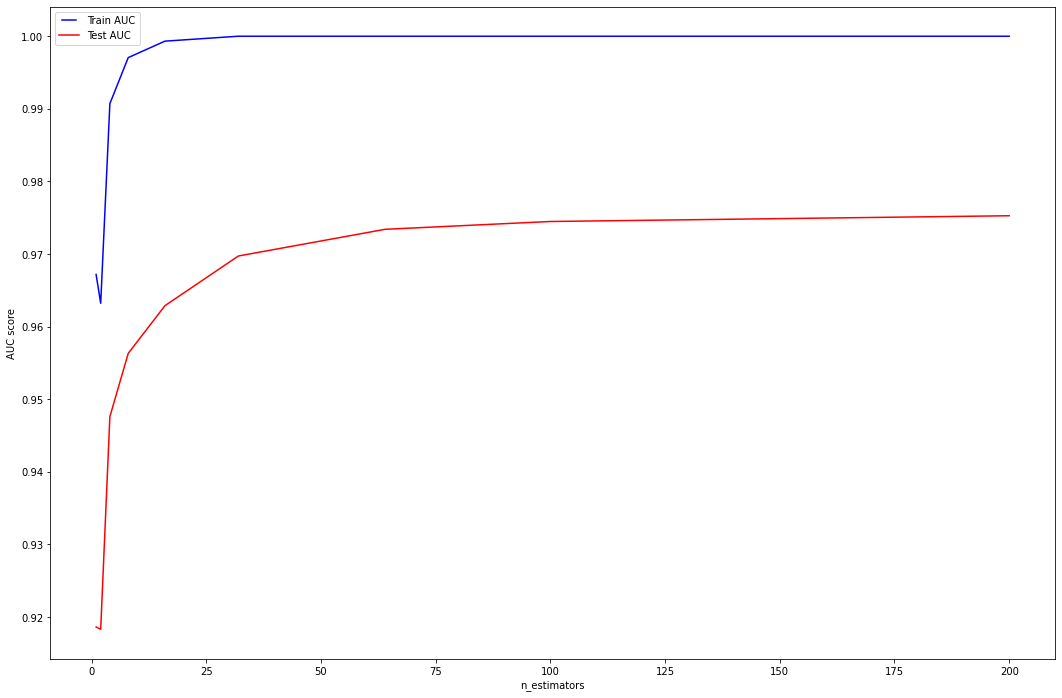

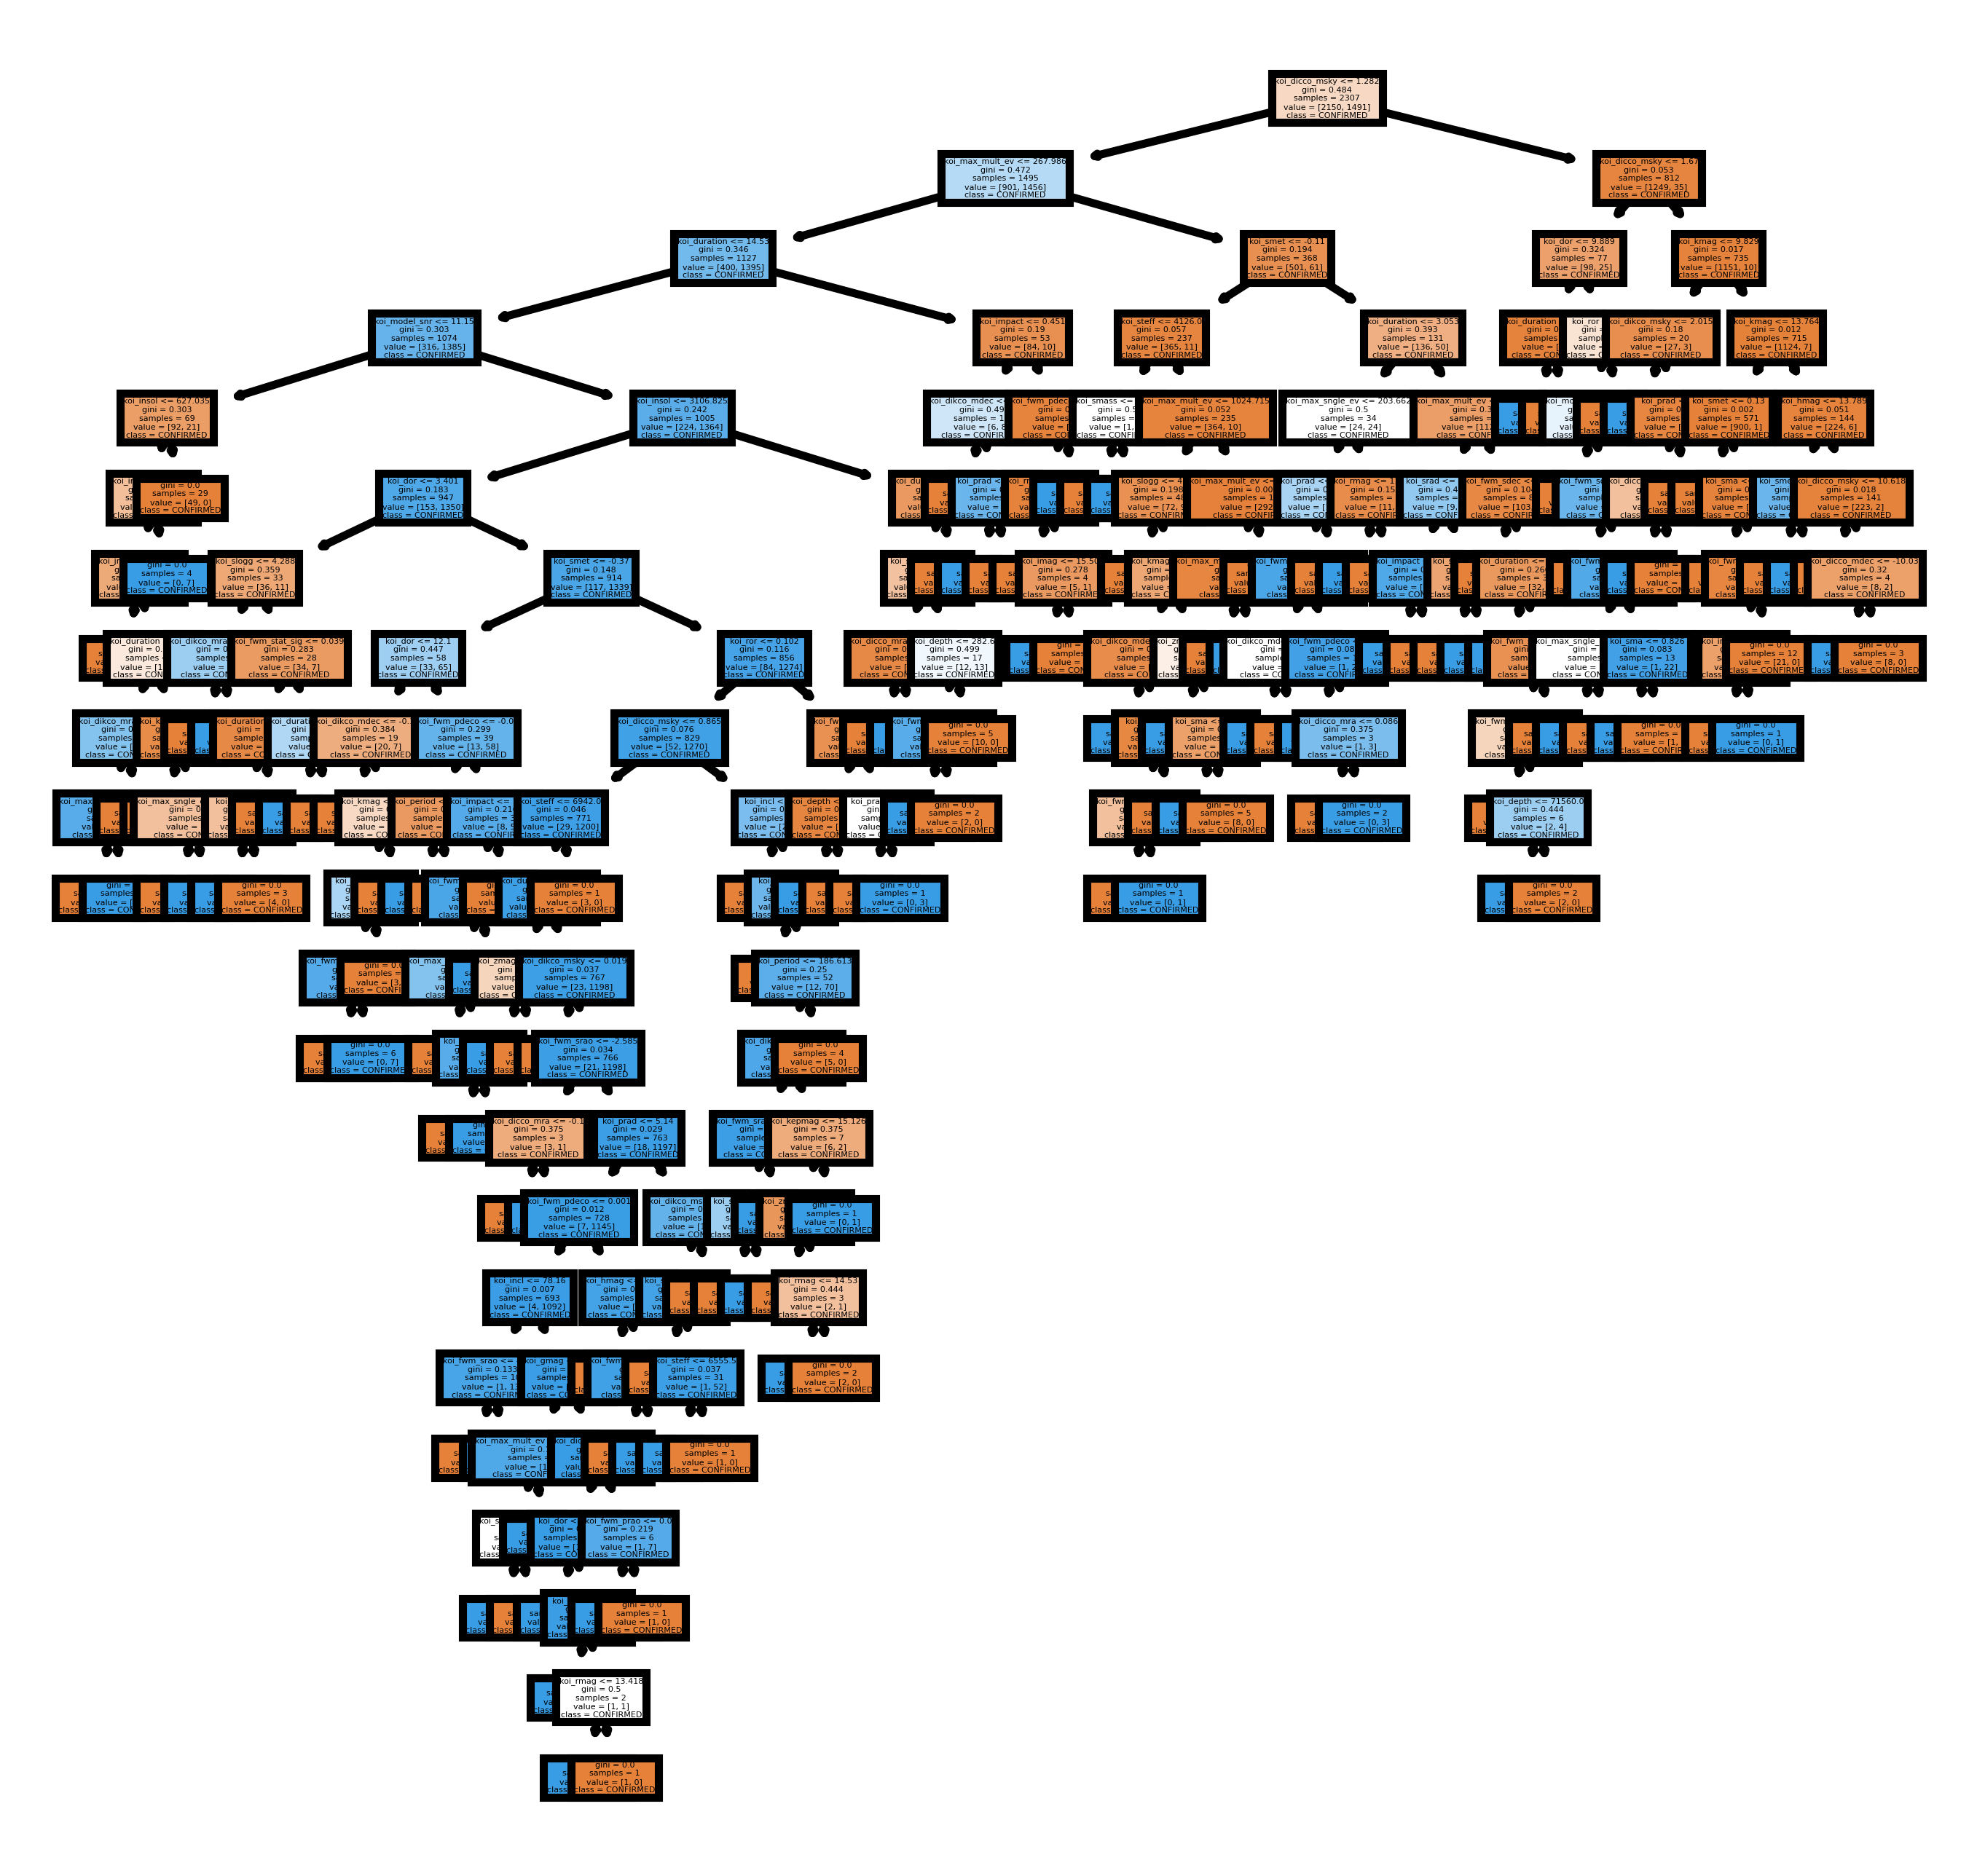

In [ ]:
from sklearn import metrics

#RANDOM FORESTS
print("RANDOM FORESTS")

nro_arvores=[1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for a in nro_arvores:    
  random_forest = RandomForestClassifier(random_state=SEED, n_estimators=a).fit(treino_x, treino_y)
  previsoes = random_forest.predict(teste_x)
  acuracia = accuracy_score(teste_y, previsoes) * 100

  train_pred = random_forest.predict(treino_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(treino_y, train_pred)
  roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)
  y_pred = random_forest.predict(teste_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(teste_y, y_pred)
  roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

  # K-fold (k=5)
  scores = cross_val_score(random_forest, x, y, cv=5, scoring='accuracy')

  # Results
  print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

  # Imprimindo o quão acurado foi o modelo
  print("A acurácia do Random Forest com nro de árvores %s foi %.2f%%" % (a,acuracia))  

  # Imprimindo o relatório de classificação
  print("Relatório de classificação: \n", classification_report(teste_y, previsoes)) 

line1, = plt.plot(nro_arvores, train_results, 'b', label='Train AUC')
line2, = plt.plot(nro_arvores, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(random_forest.estimators_[0],
              feature_names = x.columns, 
              class_names=df['koi_disposition'],
              filled = True);

GRADIENT TREE BOOSTING: O Gradient Boosting constrói um modelo aditivo de maneira progressiva; permite a otimização de funções de perda arbitrariamente diferenciáveis. Em cada estágio, as árvores de regressão nclasses são ajustadas ao gradiente negativo da função de perda de desvio binomial ou multinomial. A classificação binária é um caso especial em que apenas uma única árvore de regressão é induzida.

Para o presente trabalho foi variado o número de estimadores do Gradient Boosting, que é o número de boosting estágios a se considerar. Foram variados valores de 1 a 200. Similar ao Random Forest, quanto maior o nro do estimador, maior é a acurácia do modelo, chegando a 97.44% quando n_estimador = 200.

Conforme exibido em um gráfico, a curva AUC de treino e teste começam em um valor baixo quando o número de estimadores é 1 e começa a subir conforme se aumenta o número de árvores, chegando a valores entre 0.97 e 0.99. A curva de teste inclusive chega a cair mas no geral sobe junto com a de treino.

In [ ]:
from sklearn import metrics

#GRADIENT BOOSTING
print("GRADIENT BOOSTING")

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []

for estimator in n_estimators:
  gradient_clf = GradientBoostingClassifier(n_estimators=estimator, learning_rate=1.0, 
                                            random_state=SEED
                                            ).fit(treino_x, treino_y)
  previsoes = gradient_clf.predict(teste_x)
  acuracia = accuracy_score(teste_y, previsoes) * 100

  train_pred = gradient_clf.predict(treino_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(treino_y, train_pred)
  roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
  train_results.append(roc_auc)
  y_pred = gradient_clf.predict(teste_x)
  false_positive_rate, true_positive_rate, thresholds = roc_curve(teste_y, y_pred)
  roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
  test_results.append(roc_auc)

   # K-fold (k=5)
  scores = cross_val_score(gradient_clf, x, y, cv=5, scoring='accuracy')

  # Results
  print("K-Fold Cross Validation Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

  # Imprimindo o quão acurado foi o modelo
  print("A acurácia do Gradient Tree Boosting com %d estimators foi: %.2f%%\n" % (estimator,acuracia))

  # Imprimindo o relatório de classificação
  print("Relatório de classificação: \n", classification_report(teste_y, previsoes))   

line1, = plt.plot(n_estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title("Acurácia por nro de estimadores")
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

A Curva Característica de Operação do Receptor, ou, do inglês, Receiver Operating Characteristic Curve (ROC curve), ou, simplesmente, curva ROC, é uma representação gráfica que ilustra o desempenho (ou performance) de um sistema classificador binário à medida que o seu limiar de discriminação varia.

Para este trabalho é plotada a curva ROC para cada um dos 6 modelos de aprendizagem de máquina testados. Lembrando que os classificadores utilizados para a curva são os que possuem o máximo de vizinhos para o KNN, árvores para Decision Tree, Random Forest e Gradient Tree Boosting. Já para o SVM foi escolhido o kernel poly por ser o que apresenta melhor acurácia entre os outros (veja seção sobre o SVM).

É evidente de acordo com o plot que o valor de AUC-ROC é maior para os modelos Random Forest e Gardient Tree Boosting (os valores inclusive se sobrepõem). Por isso podemos dizer que ambos os modelos são os que melhor classficam os dados. Olhando o gráfico percebemos que o pior dos modelos é o KNNcom AUC igual a 0.8695.

Nota-se que todas as curvas dos seis modelos aqui experimentados tendem a aumentar a taxa de True Positive conforme o valor de False Positive cresce.

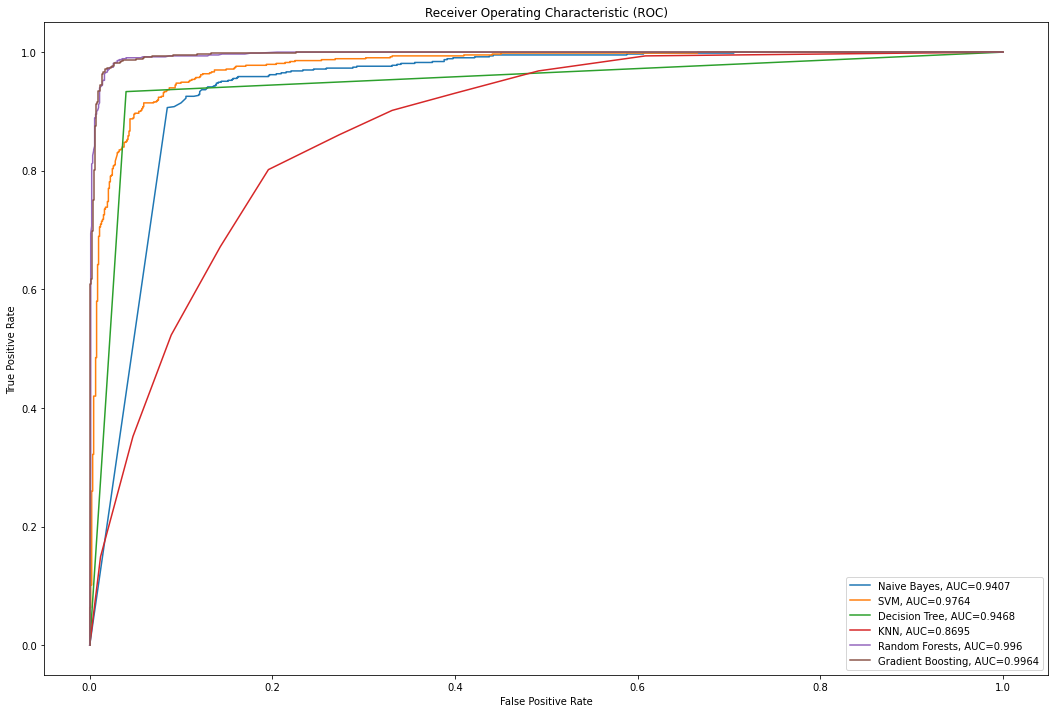

In [ ]:
#Plot ROC

SVM_clf = SVC(kernel='poly', probability=True,
                random_state=SEED).fit(treino_x_norm, treino_y)

plt.figure(0).clf()
plt.rcParams["figure.figsize"] = (18,12)

plt.title('Receiver Operating Characteristic (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#fit Naive Bayes model and plot ROC curve
y_pred = gaus_nb.predict_proba(teste_x)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="Naive Bayes, AUC="+str(auc))

#fit SVM model and plot ROC curve
y_pred = SVM_clf.predict_proba(teste_x_norm)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="SVM, AUC="+str(auc))

#fit Decision Tree model and plot ROC curve
y_pred = tree_clf.predict_proba(teste_x)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="Decision Tree, AUC="+str(auc))

#fit KNN model and plot ROC curve
y_pred = k_neigh.predict_proba(teste_x)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="KNN, AUC="+str(auc))

#fit random forest model and plot ROC curve
y_pred = random_forest.predict_proba(teste_x)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="Random Forests, AUC="+str(auc))

#fit gradient boosting model and plot ROC curve
y_pred = gradient_clf.predict_proba(teste_x)[:, 1]
fpr, tpr, _ = roc_curve(teste_y, y_pred)
auc = round(roc_auc_score(teste_y, y_pred), 4)
plt.plot(fpr,tpr,label="Gradient Boosting, AUC="+str(auc))

plt.legend()
plt.show()